<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Tradevesting/myStocks_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2023-07-28 15:42:28


In [2]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=668791fed097cab6990b01b71bb4f6965a406d5edd2d24f8e3757a3c43a5d9de
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [3]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

In [4]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-5*365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')



In [5]:
# fetch nifty200 scrips

import pandas as pd
import numpy as np

mypf = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myProspectsScrips.csv')

myts = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myTransactionsReport.csv')

mypf = mypf[mypf['InPortfolio'] == 1]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol'].unique()

stock_ids = stock_n100

#mypf = mypf[mypf.Forecast.notnull()]
#stock_ids = mypf['Symbol'].unique()

stock_ids.sort()
stock_ids

array(['5PAISA', 'AAVAS', 'AMARAJABAT', 'AMBUJACEM', 'BAJAJFINSV',
       'BAJAJHIND', 'BANDHANBNK', 'BATAINDIA', 'BAYERCROP', 'CAMS',
       'CDSL', 'CLEAN', 'DMART', 'EICHERMOT', 'EMAMILTD', 'FINEORG',
       'GICRE', 'GILLETTE', 'GLAND', 'HDFCAMC', 'HDFCBANK', 'ICICIGI',
       'INDIGOPNTS', 'INDUSINDBK', 'INFY', 'IRCTC', 'ITBEES', 'J&KBANK',
       'JMFINANCIL', 'JUBLFOOD', 'KOTAKBANK', 'LTIM', 'LUXIND',
       'METROPOLIS', 'NIACL', 'NMDC', 'PAGEIND', 'PIDILITIND', 'PNB',
       'RAJESHEXPO', 'RELAXO', 'ROSSARI', 'SAIL', 'SRF', 'STARHEALTH',
       'SUNTV', 'TCS', 'TEAMLEASE', 'UJJIVANSFB', 'VAIBHAVGBL',
       'VALIANTORG', 'WIPRO'], dtype=object)

In [6]:
# function to compute stock attributes
def get_common_features():
  def stock_prec_dev(stock_symbol):
      #stock_symbol = 'ULTRACEMCO.NS'
      short_window = 20
      mid_window = 50
      long_window = 200
      moving_avg = 'SMA'

      # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
      start = datetime.datetime(*map(int, start_date.split('-')))
      end = datetime.datetime(*map(int, end_date.split('-')))
      stock_df = yfin.Ticker(stock_symbol).history(period='7y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
      stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
      stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
      stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
      stock_df.dropna(axis = 0, inplace = True) # remove any null rows

      stock_df['Stock'] = stock_symbol

      stock_df['Close'] = round(stock_df['Close'],2)
      stock_df['Max'] = round(max(stock_df['Close']),0)
      stock_df.ta.rsi(append=True)
      #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
      stock_df['Close'] = round(stock_df['Close'],0)
      stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
      stock_df.drop(['Open', 'Low', 'High', 'Volume'
                    ], axis=1, inplace=True)

      return stock_df

  df_prec_dev = pd.DataFrame()

  #tmp = stock_prec_dev('ULTRACEMCO.NS')
  #df_perform = df_perform.append(tmp)
  for stock_id in stock_ids:
      #print(stock_id)
      #current_pe = get_current_pe(stock_id)
      stock_id = stock_id.upper() + '.NS'
      tmp = stock_prec_dev(stock_id)
      tmp['Prev_Close'] = tmp['Close'].shift(1)
      tmp = tmp.reset_index()
      tmp = tmp.tail(1)
      tmp['Avg_Cost'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['AvgCost'].values[0]
      tmp['Shares'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Shares'].values[0]
      tmp['Criteria'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Criteria'].values[0]
      tmp['Strategy'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Strategy'].values[0]
      tmp['Target'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Target'].values[0]
      tmp['LatestQtr'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['LatestQtr'].values[0]
      tmp['StarStock'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['StarStock'].values[0]
      tmp['Conviction'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Conviction'].values[0]
      tmp['Category'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Category'].values[0]
      #tmp['Curr_PE'] = current_pe
      df_prec_dev = df_prec_dev.append(tmp)

  return df_prec_dev

df_common_features = get_common_features()

In [7]:
df_common_features.reset_index(drop=True, inplace=True)
df_common_features.drop(['Date'], axis=1, inplace=True)

In [8]:
# portfolio stocks

def get_portfolio_features(df_common_features):

  df_common_features["Target"] = df_common_features["Target"].fillna(df_common_features["Max"])

  tmp_df = df_common_features[df_common_features['Stock'].isin(mypf[mypf['InPortfolio'] == 1].Stock.values)]
  print('qualified stocks: '+str(tmp_df.shape[0]))
  tmp_df['Investment'] = tmp_df['Avg_Cost'] * tmp_df['Shares']
  tmp_df['Current'] = tmp_df['Close'] * tmp_df['Shares']
  tmp_df['Previous'] = tmp_df['Prev_Close'] * tmp_df['Shares']
  tmp_df['Estimated'] = tmp_df['Target'] * tmp_df['Shares']
  tmp_df['Today P/L%'] = round((tmp_df['Current'] - tmp_df['Previous'])*100/tmp_df['Previous'],2)
  tmp_df['Current P/L%'] = round((tmp_df['Current'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['Estimated P/L%'] = round((tmp_df['Estimated'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['Juice Left%'] = tmp_df['Estimated P/L%'] - tmp_df['Current P/L%']
  investment = round(sum(tmp_df['Avg_Cost']*tmp_df['Shares']),0)
  tmp_df['Weightage%'] = round(tmp_df['Investment']*100/investment,2)
  tmp_df['Risk Ind'] = round(tmp_df['Current P/L%']*tmp_df['Weightage%'],0)

  return tmp_df

df_portfolio_features = get_portfolio_features(df_common_features)

def print_portfolio_stats(df_portfolio_features):
  investment = round(sum(df_portfolio_features['Avg_Cost']*df_portfolio_features['Shares']),0)
  current = round(sum(df_portfolio_features['Close']*df_portfolio_features['Shares']),0)
  previous = round(sum(df_portfolio_features['Prev_Close']*df_portfolio_features['Shares']),0)

  today_pnl_amount = current-previous
  today_pnl_percentage = round((current-previous)*100/previous,2)

  curr_pnl_amount = current-investment
  curr_pnl_percentage = round((current-investment)*100/investment,2)

  estimate = round(sum(df_portfolio_features['Max']*df_portfolio_features['Shares']),0)
  est_pnl_amount = estimate-investment
  est_pnl_percentage = round((estimate-investment)*100/investment,2)

  print('Investment: ', investment)
  print('Current: ', current)
  print('Today PnL: ', today_pnl_amount)
  print('Today PnL %: ', today_pnl_percentage)
  print('Current PnL: ', curr_pnl_amount)
  print('Current PnL %: ', curr_pnl_percentage)
  print('Estimate: ', estimate)
  print('Estimate PnL: ', est_pnl_amount)
  print('Estimate PnL %: ', est_pnl_percentage)
  print('-------------------')
  print('Total profit: ',round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Investment']),0))
  print('Total loss: ',round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Investment']),0))

print_portfolio_stats(df_portfolio_features)

qualified stocks: 52
Investment:  3465045.0
Current:  3673751.0
Today PnL:  16713.0
Today PnL %:  0.46
Current PnL:  208706.0
Current PnL %:  6.02
Estimate:  6143738.0
Estimate PnL:  2678693.0
Estimate PnL %:  77.31
-------------------
Total profit:  249773.0
Total loss:  -41067.0


In [9]:
cols = ['Stock', 'Close', 'Dev%_200', 'RSI_14', 'Target', 'Avg_Cost', 'Shares', 'Today P/L%', 'Current P/L%', 'Estimated P/L%', 'Juice Left%', 'Weightage%', 'Risk Ind', 'LatestQtr', 'StarStock', 'Criteria', 'Strategy', 'Conviction', 'Category']
df_portfolio_features = df_portfolio_features[cols]

if gen_output == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  df_portfolio_features.to_csv('/content/drive/My Drive/data/stocks/myStocks-Portfolio-Analysis.csv', index=False)

In [10]:
df_portfolio_features.sort_values(by = 'Current P/L%', ascending=False)

,Stock,Close,Dev%_200,RSI_14,Target,Avg_Cost,Shares,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,Weightage%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
0,5PAISA.NS,472.0,45.29,76.0,532.0,347.06,228.0,2.16,36.00,53.29,17.29,2.28,82.0,1,1.0,V40N,ATH,M,FINANCE
19,HDFCAMC.NS,2538.0,29.50,73.0,3250.0,1973.85,50.0,3.72,28.58,64.65,36.07,2.85,81.0,1,0.0,V40,ATH,H,FINANCE
17,GILLETTE.NS,5715.0,18.34,71.0,7750.0,4475.85,21.0,0.12,27.69,73.15,45.46,2.71,75.0,0,0.0,V40,ATH,H,FMCG
48,UJJIVANSFB.NS,44.0,47.67,70.0,55.0,36.90,1850.0,0.00,19.24,49.05,29.81,1.97,38.0,1,1.0,V40N,ATH,M,BANKS
21,ICICIGI.NS,1374.0,17.21,60.0,1600.0,1177.58,84.0,1.18,16.68,35.87,19.19,2.85,48.0,1,1.0,V40,ATH,H,INSURANCE
45,SUNTV.NS,543.0,16.78,75.0,900.0,473.49,108.0,2.45,14.68,90.08,75.40,1.48,22.0,0,1.0,V40N,ATH,M,ENTERTAINMENT
16,GICRE.NS,198.0,23.56,64.0,370.0,174.18,231.0,-1.49,13.68,112.42,98.74,1.16,16.0,0,0.0,VR,2T3Y,L,INSURANCE
10,CDSL.NS,1221.0,12.33,66.0,1600.0,1082.25,70.0,-0.33,12.82,47.84,35.02,2.19,28.0,0,1.0,VR,ATH,L,MISC
38,PNB.NS,62.0,23.90,61.0,150.0,54.97,1400.0,0.00,12.79,172.88,160.09,2.22,28.0,1,1.0,VR,ATH,M,BANKS
7,BATAINDIA.NS,1716.0,7.71,66.0,2000.0,1523.62,100.0,0.76,12.63,31.27,18.64,4.40,56.0,0,0.0,V40,ATH,H,FOOTWEAR


In [11]:
df_portfolio_features.sort_values(by = 'Juice Left%', ascending=True)

,Stock,Close,Dev%_200,RSI_14,Target,Avg_Cost,Shares,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,Weightage%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
37,PIDILITIND.NS,2616.0,4.09,50.0,2780.0,2504.06,30.0,0.50,4.47,11.02,6.55,2.17,10.0,0,1.0,V40,ATH,H,CHEMICALS
13,EICHERMOT.NS,3355.0,0.24,48.0,3700.0,3260.20,15.0,0.81,2.91,13.49,10.58,1.41,4.0,0,1.0,V40N,ATH,H,AUTO
4,BAJAJFINSV.NS,1585.0,6.87,49.0,1800.0,1454.93,52.0,-1.86,8.94,23.72,14.78,2.18,19.0,1,1.0,V40,ATH,H,FINANCE
46,TCS.NS,3355.0,3.56,51.0,3900.0,3231.00,16.0,-1.24,3.84,20.71,16.87,1.49,6.0,1,1.0,V40,ATH,H,IT
0,5PAISA.NS,472.0,45.29,76.0,532.0,347.06,228.0,2.16,36.00,53.29,17.29,2.28,82.0,1,1.0,V40N,ATH,M,FINANCE
7,BATAINDIA.NS,1716.0,7.71,66.0,2000.0,1523.62,100.0,0.76,12.63,31.27,18.64,4.40,56.0,0,0.0,V40,ATH,H,FOOTWEAR
21,ICICIGI.NS,1374.0,17.21,60.0,1600.0,1177.58,84.0,1.18,16.68,35.87,19.19,2.85,48.0,1,1.0,V40,ATH,H,INSURANCE
30,KOTAKBANK.NS,1877.0,1.78,48.0,2270.0,1955.95,26.0,0.16,-4.04,16.06,20.10,1.47,-6.0,1,1.0,V40,BTT,L,BANKS
35,NMDC.NS,113.0,-0.40,64.0,140.0,122.55,265.0,0.89,-7.79,14.24,22.03,0.94,-7.0,0,0.0,VR,ATH,M,MINING
43,SRF.NS,2170.0,-7.73,39.0,2666.0,2222.00,14.0,0.37,-2.34,19.98,22.32,0.90,-2.0,1,0.0,VR,ATH,M,CHEMICALS


In [12]:
df_portfolio_features.sort_values(by = 'RSI_14', ascending=True)

,Stock,Close,Dev%_200,RSI_14,Target,Avg_Cost,Shares,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,Weightage%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
11,CLEAN.NS,1286.0,-11.00,28.0,2500.0,1365.11,39.0,-0.54,-5.80,83.14,88.94,1.54,-9.0,0,1.0,VR,2T3Y,L,CHEMICALS
15,FINEORG.NS,4476.0,-13.01,32.0,7000.0,4697.43,11.0,0.31,-4.71,49.02,53.73,1.49,-7.0,1,0.0,V40N,ATH,M,CHEMICALS
47,TEAMLEASE.NS,2315.0,-5.16,39.0,4550.0,2279.93,21.0,-1.03,1.54,99.57,98.03,1.38,2.0,1,1.0,V40N,2T3Y,M,MISC
43,SRF.NS,2170.0,-7.73,39.0,2666.0,2222.00,14.0,0.37,-2.34,19.98,22.32,0.90,-2.0,1,0.0,VR,ATH,M,CHEMICALS
6,BANDHANBNK.NS,217.0,-7.62,39.0,600.0,244.52,400.0,0.00,-11.25,145.38,156.63,2.82,-32.0,1,0.0,VR,2T3Y,M,BANKS
8,BAYERCROP.NS,4394.0,-0.64,39.0,6050.0,4346.57,16.0,-0.16,1.09,39.19,38.10,2.01,2.0,0,1.0,V40N,ATH,M,CHEMICALS
39,RAJESHEXPO.NS,512.0,-22.70,40.0,835.0,555.25,130.0,0.99,-7.79,50.38,58.17,2.08,-16.0,0,1.0,V40N,ATH,M,JEWELLERY
31,LTIM.NS,4844.0,4.22,42.0,7000.0,4987.59,10.0,-0.37,-2.88,40.35,43.23,1.44,-4.0,1,1.0,V200,ATH,M,IT
2,AMARAJABAT.NS,624.0,4.94,43.0,1010.0,625.25,72.0,-0.79,-0.20,61.54,61.74,1.30,-0.0,0,1.0,V200,ATH,M,AUTO
20,HDFCBANK.NS,1644.0,2.72,44.0,2050.0,1683.55,30.0,-1.73,-2.35,21.77,24.12,1.46,-3.0,1,1.0,V40,BTT,H,BANKS


In [13]:
df_portfolio_features.sort_values(by = 'Estimated P/L%', ascending=False)

,Stock,Close,Dev%_200,RSI_14,Target,Avg_Cost,Shares,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,Weightage%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
18,GLAND.NS,1292.0,-7.71,74.0,3900.0,1225.87,55.0,1.97,5.39,218.14,212.75,1.95,11.0,0,0.0,VR,2T3Y,L,PHARMA
50,VALIANTORG.NS,517.0,-4.81,48.0,1550.0,532.61,185.0,2.58,-2.93,191.02,193.95,2.84,-8.0,0,0.0,VR,2T3Y,L,CHEMICALS
34,NIACL.NS,122.0,10.55,58.0,333.0,117.07,390.0,0.00,4.21,184.45,180.24,1.32,6.0,0,0.0,VR,ATH,L,INSURANCE
32,LUXIND.NS,1555.0,3.38,59.0,4200.0,1493.72,51.0,-3.54,4.10,181.18,177.08,2.20,9.0,0,0.0,V40N,2T3Y,M,TEXTILES
49,VAIBHAVGBL.NS,339.0,7.29,65.0,875.0,317.48,144.0,-0.88,6.78,175.61,168.83,1.32,9.0,0,0.0,VR,2T3Y,L,JEWELLERY
38,PNB.NS,62.0,23.90,61.0,150.0,54.97,1400.0,0.00,12.79,172.88,160.09,2.22,28.0,1,1.0,VR,ATH,M,BANKS
6,BANDHANBNK.NS,217.0,-7.62,39.0,600.0,244.52,400.0,0.00,-11.25,145.38,156.63,2.82,-32.0,1,0.0,VR,2T3Y,M,BANKS
28,JMFINANCIL.NS,77.0,12.94,65.0,160.0,69.17,675.0,4.05,11.32,131.31,119.99,1.35,15.0,0,0.0,VR,2T3Y,L,FINANCE
33,METROPOLIS.NS,1391.0,1.57,44.0,3100.0,1365.98,22.0,-1.07,1.83,126.94,125.11,0.87,2.0,0,0.0,VR,ATH,L,HEALTHCARE
16,GICRE.NS,198.0,23.56,64.0,370.0,174.18,231.0,-1.49,13.68,112.42,98.74,1.16,16.0,0,0.0,VR,2T3Y,L,INSURANCE


In [14]:
df_portfolio_features.sort_values(by = 'Weightage%', ascending=False)

,Stock,Close,Dev%_200,RSI_14,Target,Avg_Cost,Shares,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,Weightage%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
22,INDIGOPNTS.NS,1575.0,22.38,80.0,2600.0,1407.73,124.0,2.87,11.88,84.69,72.81,5.04,60.0,0,1.0,V40N,2T3Y,M,PAINTS
36,PAGEIND.NS,37312.0,-9.91,50.0,50000.0,38548.77,4.0,0.18,-3.21,29.71,32.92,4.45,-14.0,0,1.0,V40,ATH,H,APPARELS
7,BATAINDIA.NS,1716.0,7.71,66.0,2000.0,1523.62,100.0,0.76,12.63,31.27,18.64,4.40,56.0,0,0.0,V40,ATH,H,FOOTWEAR
24,INFY.NS,1340.0,-4.73,48.0,1800.0,1324.07,104.0,-0.96,1.20,35.94,34.74,3.97,5.0,1,1.0,V40,ATH,H,IT
26,ITBEES.NS,31.0,3.50,51.0,40.0,31.49,3350.0,0.00,-1.56,27.02,28.58,3.04,-5.0,0,1.0,AR,ATH,L,IT
21,ICICIGI.NS,1374.0,17.21,60.0,1600.0,1177.58,84.0,1.18,16.68,35.87,19.19,2.85,48.0,1,1.0,V40,ATH,H,INSURANCE
19,HDFCAMC.NS,2538.0,29.50,73.0,3250.0,1973.85,50.0,3.72,28.58,64.65,36.07,2.85,81.0,1,0.0,V40,ATH,H,FINANCE
50,VALIANTORG.NS,517.0,-4.81,48.0,1550.0,532.61,185.0,2.58,-2.93,191.02,193.95,2.84,-8.0,0,0.0,VR,2T3Y,L,CHEMICALS
6,BANDHANBNK.NS,217.0,-7.62,39.0,600.0,244.52,400.0,0.00,-11.25,145.38,156.63,2.82,-32.0,1,0.0,VR,2T3Y,M,BANKS
17,GILLETTE.NS,5715.0,18.34,71.0,7750.0,4475.85,21.0,0.12,27.69,73.15,45.46,2.71,75.0,0,0.0,V40,ATH,H,FMCG


In [15]:
df_portfolio_features.sort_values(by = 'Risk Ind', ascending=True)

,Stock,Close,Dev%_200,RSI_14,Target,Avg_Cost,Shares,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,Weightage%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
6,BANDHANBNK.NS,217.0,-7.62,39.0,600.0,244.52,400.0,0.00,-11.25,145.38,156.63,2.82,-32.0,1,0.0,VR,2T3Y,M,BANKS
39,RAJESHEXPO.NS,512.0,-22.70,40.0,835.0,555.25,130.0,0.99,-7.79,50.38,58.17,2.08,-16.0,0,1.0,V40N,ATH,M,JEWELLERY
36,PAGEIND.NS,37312.0,-9.91,50.0,50000.0,38548.77,4.0,0.18,-3.21,29.71,32.92,4.45,-14.0,0,1.0,V40,ATH,H,APPARELS
11,CLEAN.NS,1286.0,-11.00,28.0,2500.0,1365.11,39.0,-0.54,-5.80,83.14,88.94,1.54,-9.0,0,1.0,VR,2T3Y,L,CHEMICALS
50,VALIANTORG.NS,517.0,-4.81,48.0,1550.0,532.61,185.0,2.58,-2.93,191.02,193.95,2.84,-8.0,0,0.0,VR,2T3Y,L,CHEMICALS
35,NMDC.NS,113.0,-0.40,64.0,140.0,122.55,265.0,0.89,-7.79,14.24,22.03,0.94,-7.0,0,0.0,VR,ATH,M,MINING
15,FINEORG.NS,4476.0,-13.01,32.0,7000.0,4697.43,11.0,0.31,-4.71,49.02,53.73,1.49,-7.0,1,0.0,V40N,ATH,M,CHEMICALS
30,KOTAKBANK.NS,1877.0,1.78,48.0,2270.0,1955.95,26.0,0.16,-4.04,16.06,20.10,1.47,-6.0,1,1.0,V40,BTT,L,BANKS
26,ITBEES.NS,31.0,3.50,51.0,40.0,31.49,3350.0,0.00,-1.56,27.02,28.58,3.04,-5.0,0,1.0,AR,ATH,L,IT
31,LTIM.NS,4844.0,4.22,42.0,7000.0,4987.59,10.0,-0.37,-2.88,40.35,43.23,1.44,-4.0,1,1.0,V200,ATH,M,IT


In [16]:
# SIP based on portfolio
df_portfolio_features[(df_portfolio_features['Weightage%'] < 2) & (df_portfolio_features['Dev%_200'] < 0)].sort_values(by = 'RSI_14', ascending=True)

,Stock,Close,Dev%_200,RSI_14,Target,Avg_Cost,Shares,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,Weightage%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
11,CLEAN.NS,1286.0,-11.00,28.0,2500.0,1365.11,39.0,-0.54,-5.80,83.14,88.94,1.54,-9.0,0,1.0,VR,2T3Y,L,CHEMICALS
15,FINEORG.NS,4476.0,-13.01,32.0,7000.0,4697.43,11.0,0.31,-4.71,49.02,53.73,1.49,-7.0,1,0.0,V40N,ATH,M,CHEMICALS
43,SRF.NS,2170.0,-7.73,39.0,2666.0,2222.00,14.0,0.37,-2.34,19.98,22.32,0.90,-2.0,1,0.0,VR,ATH,M,CHEMICALS
47,TEAMLEASE.NS,2315.0,-5.16,39.0,4550.0,2279.93,21.0,-1.03,1.54,99.57,98.03,1.38,2.0,1,1.0,V40N,2T3Y,M,MISC
12,DMART.NS,3714.0,-0.72,47.0,5100.0,3659.46,14.0,0.57,1.49,39.36,37.87,1.48,2.0,1,1.0,AR,ATH,M,FMCG
35,NMDC.NS,113.0,-0.40,64.0,140.0,122.55,265.0,0.89,-7.79,14.24,22.03,0.94,-7.0,0,0.0,VR,ATH,M,MINING
1,AAVAS.NS,1605.0,-7.48,65.0,3075.0,1453.92,37.0,1.07,10.39,111.50,101.11,1.55,16.0,0,1.0,VR,2T3Y,M,FINANCE
18,GLAND.NS,1292.0,-7.71,74.0,3900.0,1225.87,55.0,1.97,5.39,218.14,212.75,1.95,11.0,0,0.0,VR,2T3Y,L,PHARMA


<Axes: ylabel='Weight%'>

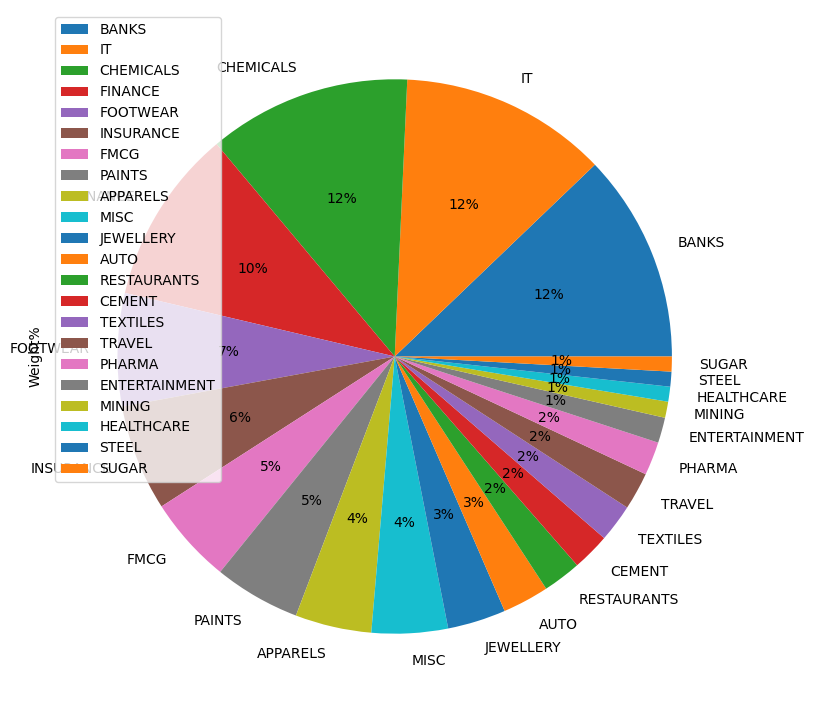

In [38]:
tmp_df = df_portfolio_features.groupby('Category')['Weightage%'].agg(['sum'])
tmp_df = tmp_df.rename({'sum': 'Weight%'}, axis='columns')
tmp_df = tmp_df.sort_values(by = 'Weight%', ascending=False)
tmp_df.plot.pie(y='Weight%', autopct='%1.0f%%', figsize=(9, 9))

<Axes: ylabel='Weight%'>

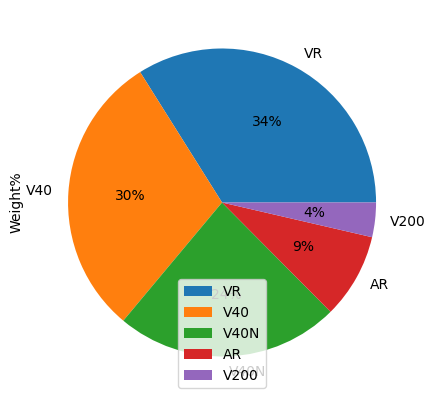

In [41]:
tmp_df = df_portfolio_features.groupby('Criteria')['Weightage%'].agg(['sum'])
tmp_df = tmp_df.rename({'sum': 'Weight%'}, axis='columns')
tmp_df = tmp_df.sort_values(by = 'Weight%', ascending=False)
tmp_df.plot.pie(y='Weight%', autopct='%1.0f%%', figsize=(5, 5))

<Axes: ylabel='Weight%'>

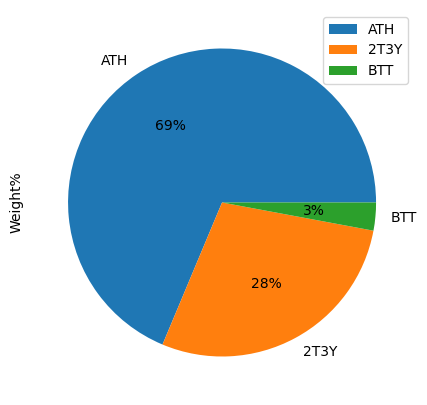

In [42]:
tmp_df = df_portfolio_features.groupby('Strategy')['Weightage%'].agg(['sum'])
tmp_df = tmp_df.rename({'sum': 'Weight%'}, axis='columns')
tmp_df = tmp_df.sort_values(by = 'Weight%', ascending=False)
tmp_df.plot.pie(y='Weight%', autopct='%1.0f%%', figsize=(5, 5))

<Axes: ylabel='Weight%'>

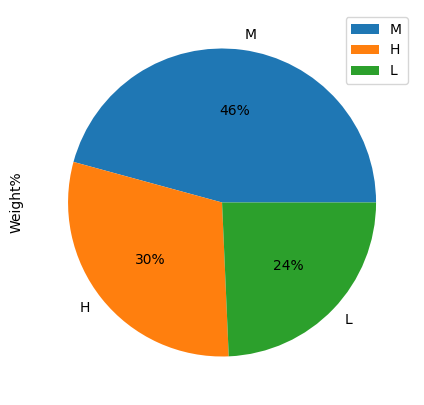

In [43]:
tmp_df = df_portfolio_features.groupby('Conviction')['Weightage%'].agg(['sum'])
tmp_df = tmp_df.rename({'sum': 'Weight%'}, axis='columns')
tmp_df = tmp_df.sort_values(by = 'Weight%', ascending=False)
tmp_df.plot.pie(y='Weight%', autopct='%1.0f%%', figsize=(5, 5))

In [21]:
#myts['Value'] = myts['Value'].str.replace(',', '').astype(float)

In [22]:
#sum(myts[(myts['Type'] == 'Buy')]['Value'])

In [23]:
#sum(myts[(myts['Type'] == 'Sell')]['Value'])